In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric 
import torch_geometric.nn as gnn
from torch_geometric.loader import NeighborSampler,NeighborLoader
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import os   
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "Models/Sage/"
print(device)

cuda


In [6]:
from ogb.nodeproppred import PygNodePropPredDataset,Evaluator

data_path = "Dataset/"
dataset = PygNodePropPredDataset("ogbn-products",data_path)

In [7]:
split_idx = dataset.get_idx_split()
split_idx.keys()
train_idx = split_idx["train"]
val_idx = split_idx["valid"]
test_idx = split_idx["test"]

print(f"Nodes of train Data : {train_idx.shape[0]}")
print(f"Nodes of valid Data :{val_idx.shape[0]}")
print(f"Nodes of test Data :{test_idx.shape[0]}")

Nodes of train Data : 196615
Nodes of valid Data :39323
Nodes of test Data :2213091


In [8]:
data = dataset[0]
print(data)



Data(num_nodes=2449029, edge_index=[2, 123718280], x=[2449029, 100], y=[2449029, 1])


In [9]:
print(f"Num of nodes in graph : {data.num_nodes}")
print(f"Num of edges in graph : {data.edge_index.shape[1]}")
print(f"Num of features of node in graph  : {data.x.shape[1]}")

Num of nodes in graph : 2449029
Num of edges in graph : 123718280
Num of features of node in graph  : 100


In [10]:
labels = data.y.unique()
df_labels = pd.read_csv("Dataset/ogbn_products/mapping/labelidx2productcategory.csv.gz")
keys = df_labels["label idx"].values
values = df_labels["product category"].values

labels_mapping = dict(zip(keys,values))

print(f"the labels are :{labels}")
print(f"label name by idx :{labels_mapping}")
df_labels.head(df_labels.shape[0])



the labels are :tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46])
label name by idx :{0: 'Home & Kitchen', 1: 'Health & Personal Care', 2: 'Beauty', 3: 'Sports & Outdoors', 4: 'Books', 5: 'Patio, Lawn & Garden', 6: 'Toys & Games', 7: 'CDs & Vinyl', 8: 'Cell Phones & Accessories', 9: 'Grocery & Gourmet Food', 10: 'Arts, Crafts & Sewing', 11: 'Clothing, Shoes & Jewelry', 12: 'Electronics', 13: 'Movies & TV', 14: 'Software', 15: 'Video Games', 16: 'Automotive', 17: 'Pet Supplies', 18: 'Office Products', 19: 'Industrial & Scientific', 20: 'Musical Instruments', 21: 'Tools & Home Improvement', 22: 'Magazine Subscriptions', 23: 'Baby Products', 24: nan, 25: 'Appliances', 26: 'Kitchen & Dining', 27: 'Collectibles & Fine Art', 28: 'All Beauty', 29: 'Luxury Beauty', 30: 'Amazon Fashion', 31: 'Computers', 32: 'All Electronics', 33: 'Pu

,label idx,product category
0,0,Home & Kitchen
1,1,Health & Personal Care
2,2,Beauty
3,3,Sports & Outdoors
4,4,Books
5,5,"Patio, Lawn & Garden"
6,6,Toys & Games
7,7,CDs & Vinyl
8,8,Cell Phones & Accessories
9,9,Grocery & Gourmet Food


In [11]:
from pandas.core.common import flatten
from collections import Counter

y = data.y.cpu().numpy().flatten()
labels_count = Counter(y)
for i in labels_count.keys():
    print(f"{labels_mapping[i]} :",labels_count[i])

Home & Kitchen : 114294
Health & Personal Care : 109832
Beauty : 116043
Sports & Outdoors : 151061
Books : 668950
Patio, Lawn & Garden : 40715
Toys & Games : 158771
CDs & Vinyl : 172199
Cell Phones & Accessories : 110796
Grocery & Gourmet Food : 67358
Arts, Crafts & Sewing : 52345
Clothing, Shoes & Jewelry : 32937
Electronics : 131886
Movies & TV : 101541
Software : 3079
Video Games : 26911
Automotive : 83594
Pet Supplies : 42337
Office Products : 49019
Industrial & Scientific : 17438
Musical Instruments : 22575
Tools & Home Improvement : 80795
Magazine Subscriptions : 879
Baby Products : 3653
nan : 45406
Appliances : 3024
Kitchen & Dining : 553
Collectibles & Fine Art : 259
All Beauty : 1969
Luxury Beauty : 1561
Amazon Fashion : 277
Computers : 418
All Electronics : 513
Purchase Circles : 29
MP3 Players & Accessories : 154
Gift Cards : 44
Office & School Supplies : 630
Home Improvement : 514
Camera & Photo : 91
GPS & Navigation : 37
Digital Music : 6
Car Electronics : 61
Baby : 32500


In [12]:
X = data.x.to(device)
y = data.y.squeeze().to(device)
X.device

device(type='cuda', index=0)

In [9]:


train_loader = NeighborSampler(data.edge_index,node_idx=train_idx,sizes=[15,10,5],batch_size=1024,num_workers=12,shuffle=True)




c:\dev\python\lib\site-packages\torch\utils\data\dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 6 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
def test_data(train_loader):
    for i,(batch_size,n_id,adjs) in enumerate(train_loader):
        print(f"batch size = {batch_size} | n_id.shape = {n_id.shape[0]}")
        for k,(edge_index,_,size) in enumerate(adjs):
            print(f"\tk:{k}")
            print(f"\t\tedge index :{edge_index.shape}")
            print(f"\t\tsize :{size}")
        if i ==1 :
            break
test_data(train_loader)


batch size = 1024 | n_id.shape = 441903
	k:0
		edge index :torch.Size([2, 659708])
		size :(441903, 132337)
	k:1
		edge index :torch.Size([2, 156824])
		size :(132337, 15802)
	k:2
		edge index :torch.Size([2, 15119])
		size :(15802, 1024)
batch size = 1024 | n_id.shape = 443032
	k:0
		edge index :torch.Size([2, 660125])
		size :(443032, 132444)
	k:1
		edge index :torch.Size([2, 156478])
		size :(132444, 15780)
	k:2
		edge index :torch.Size([2, 15141])
		size :(15780, 1024)


# Build Model

In [14]:

class Sage(nn.Module):
    def __init__(self,in_dim,out_dim,hidden_dim,num_layers):
        super(Sage,self).__init__()
        self.num_layers = num_layers
        self.convs = nn.ModuleList()

        self.convs.append(gnn.SAGEConv(in_dim,hidden_dim))
        for _ in range(num_layers-2):
            self.convs.append(gnn.SAGEConv(hidden_dim,hidden_dim))
        self.convs.append(gnn.SAGEConv(hidden_dim,out_dim))


    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
    
    def forward(self,x,adj):
        for k,(edge_index,_,size) in enumerate(adj):
            x_targets = x[:size[1]] # Target Nodes are first always
            x = self.convs[k]((x,x_targets),edge_index)
            if k != self.num_layers-1:
                x = F.relu(x)
                x = F.dropout(x,p=0.5,training=self.training)
        return x.log_softmax(dim=-1)
    def inference(self,x_all):
        pbar = tqdm(total=self.num_layers*x_all.shape[0])
        pbar.set_description("Evaluating :")
        for i in range(self.num_layers):
            xs = []
            for batch_size,n_id,adj in subgraph_loader:
                edge_index,_,size = adj.to(device)
                x = x_all[n_id].to(device)
                x_target = x[:size[1]]

                x = self.convs[i]((x,x_target),edge_index)
                if i != self.num_layers - 1:
                    x = F.relu(x)
                 
                xs.append(x.cpu())
                pbar.update(batch_size)
            x_all = torch.cat(xs,dim=0)
            
        pbar.close()

        return x_all

        





model = Sage(dataset.num_features,dataset.num_classes,256,num_layers=3).to(device)

In [15]:
def trainstep(epoch):
    model.train()


    pbar = tqdm(total=train_idx.shape[0])
    pbar.set_description(f"Epoch {epoch}:")
    
    total_loss=total_true = 0
    for batch_size,n_id,adjs in train_loader:
        adjs = [adj.to(device) for adj in adjs]

        # Forward
        optimizer.zero_grad()
        out = model(X[n_id],adjs)
        
        #backward
        loss = F.nll_loss(out, y[n_id[:batch_size]])
        loss.backward()
        optimizer.step()

        total_loss += float(loss)
        total_true += int(out.argmax(dim=-1).eq(y[n_id[:batch_size]]).sum())

        pbar.update(batch_size)
    pbar.close()

    loss = total_loss/len(train_loader)
    acc = total_true/train_idx.shape[0]
    
    return loss,acc


def save_checkpoint(file_name):
    print(f"=> Saving checkpoint at {file_name}..")
    torch.save(model,file_name)



@torch.no_grad()
def test():
    model.eval()
    evaluator = Evaluator(name='ogbn-products')
    out = model.inference(X)
    y_true = y.cpu().unsqueeze(-1)
    y_pred = out.argmax(dim=-1,keepdim=True)

    train_acc = evaluator.eval({"y_true":y_true[train_idx],"y_pred":y_pred[train_idx]})["acc"]
    val_acc = evaluator.eval({"y_true":y_true[val_idx],"y_pred":y_pred[val_idx]})["acc"]
    test_acc = evaluator.eval({"y_true":y_true[test_idx],"y_pred":y_pred[test_idx]})["acc"]
    

    return train_acc,val_acc,test_acc






learning_rate=3e-3
num_epochs = 15
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)




In [13]:
history_loss = []
history_acc = []
for epoch in range(num_epochs):
    loss,acc = trainstep(epoch)
    print(f"Epch {epoch}, Loss: {loss:.4f}, Train_acc: {acc:.4f}")
    history_acc.append(acc)
    history_loss.append(loss)

Epoch 0:: 100%|██████████| 196615/196615 [01:45<00:00, 1871.07it/s]


Epch 0, Loss: 0.6463, Train_acc: 0.8298


Epoch 1:: 100%|██████████| 196615/196615 [01:44<00:00, 1886.30it/s]


Epch 1, Loss: 0.3883, Train_acc: 0.8935


Epoch 2:: 100%|██████████| 196615/196615 [01:48<00:00, 1812.15it/s]


Epch 2, Loss: 0.3486, Train_acc: 0.9025


Epoch 3:: 100%|██████████| 196615/196615 [01:55<00:00, 1705.24it/s]


Epch 3, Loss: 0.3321, Train_acc: 0.9069


Epoch 4:: 100%|██████████| 196615/196615 [01:57<00:00, 1668.07it/s]


Epch 4, Loss: 0.3173, Train_acc: 0.9099


Epoch 5:: 100%|██████████| 196615/196615 [01:54<00:00, 1717.01it/s]


Epch 5, Loss: 0.3088, Train_acc: 0.9132


Epoch 6:: 100%|██████████| 196615/196615 [01:58<00:00, 1665.79it/s]


Epch 6, Loss: 0.3094, Train_acc: 0.9135


Epoch 7:: 100%|██████████| 196615/196615 [01:55<00:00, 1707.85it/s]


Epch 7, Loss: 0.3136, Train_acc: 0.9118


Epoch 8:: 100%|██████████| 196615/196615 [01:52<00:00, 1750.60it/s]


Epch 8, Loss: 0.3087, Train_acc: 0.9146


Epoch 9:: 100%|██████████| 196615/196615 [01:53<00:00, 1737.80it/s]


Epch 9, Loss: 0.3138, Train_acc: 0.9110


Epoch 10:: 100%|██████████| 196615/196615 [01:47<00:00, 1833.58it/s]


Epch 10, Loss: 0.3046, Train_acc: 0.9135


Epoch 11:: 100%|██████████| 196615/196615 [01:51<00:00, 1759.80it/s]


Epch 11, Loss: 0.2868, Train_acc: 0.9174


Epoch 12:: 100%|██████████| 196615/196615 [01:55<00:00, 1708.22it/s]


Epch 12, Loss: 0.2866, Train_acc: 0.9185


Epoch 13:: 100%|██████████| 196615/196615 [02:17<00:00, 1431.62it/s]


Epch 13, Loss: 0.2811, Train_acc: 0.9194


Epoch 14:: 100%|██████████| 196615/196615 [02:03<00:00, 1597.74it/s]

Epch 14, Loss: 0.2835, Train_acc: 0.9193


In [ ]:
history = {"epochs":[i for i in range(num_epochs)],
           "loss":history_loss,
           "acc":history_acc}


file_name = os.path.join(MODEL_PATH,"GnnAmazon.pt")
history = pd.DataFrame(history)

history.to_csv(os.path.join(MODEL_PATH,"history.csv"))
save_checkpoint(file_name)

In [21]:
file_name = os.path.join(MODEL_PATH,"GnnAmazon.pt")
model = torch.load(file_name,map_location=device)

In [22]:
subgraph_loader = NeighborSampler(data.edge_index, node_idx=None, sizes=[-1],
                                  batch_size=4096, shuffle=False,
                                  num_workers=6)

In [23]:
train_acc,val_acc,test_acc = test()

Evaluating :: 100%|██████████| 7347087/7347087 [05:13<00:00, 23429.95it/s] 


In [24]:
print(f"Train accuracy : {train_acc:.2f}")
print(f"Validation accuracy : {val_acc:.2f}")
print(f"Test accuracy : {test_acc:.2f}")

Train accuracy : 0.93
Validation accuracy : 0.92
Test accuracy : 0.79


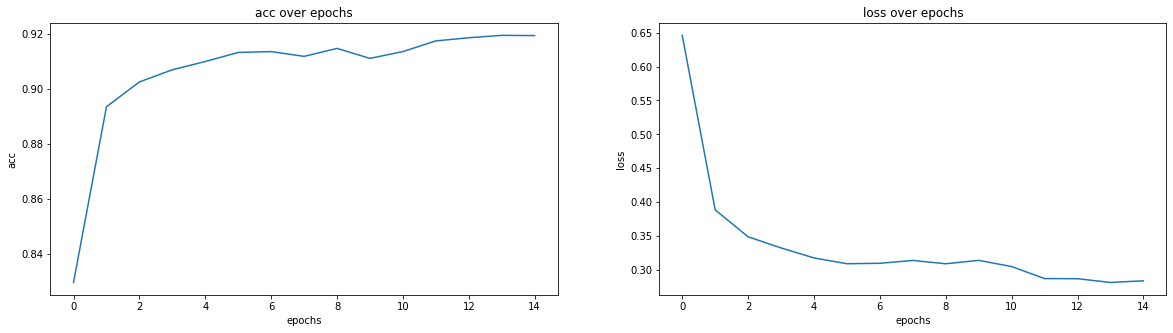

In [30]:
history = pd.read_csv(os.path.join(MODEL_PATH,"history.csv"))
x = np.arange(history.shape[0])
fig , axes = plt.subplots(1,2,figsize = (20,5))
infos = ["acc","loss"]

for i in range(2):
    axes[i].set_title(f"{infos[i]} over epochs")
    axes[i].set_ylabel(f"{infos[i]}")
    axes[i].set_xlabel(f"epochs")
    axes[i].plot(x,history[infos[i]])
    
